# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

There are 17 marketing campaigns in the dataset.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [62]:
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC

In [63]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [64]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



Convert following fields to numeric using one hot:
job, marital, education, default, housing, loan, contact, month, day_of_week, poutcome

Normalize numeric fields:
age, duration, campaign, pdays, previous, emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m, nr.employed

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

Business Objective: Identify the best classification model that will accurately predict the conditions/features of a successful marketing campaign. What are the client, marketing campaign, and socio economic features that will provide the best chance of making the client sign up after the campaign.

In [66]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


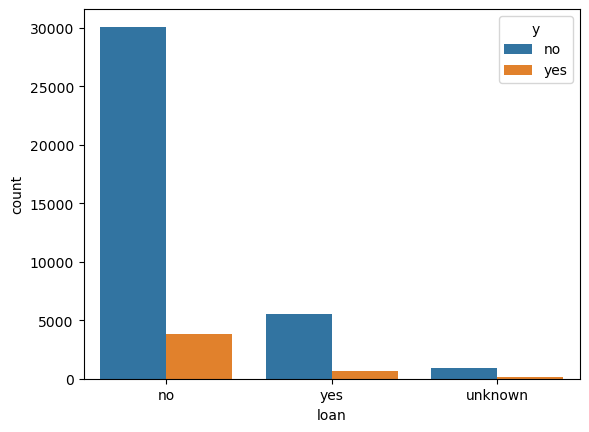

In [67]:


# Load a sample dataset
#tips = sns.load_dataset('DFtips')

# Create a count plot
sns.countplot(x='loan', hue='y', data=df)

# Display the plot
plt.show()

In [68]:
# check value_counts for non numeric columns
non_numeric_columns = df.select_dtypes(exclude=['int64', 'float64']).columns
for column in non_numeric_columns:
    print(df[column].value_counts())

job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64
marital
married     24928
single      11568
divorced     4612
unknown        80
Name: count, dtype: int64
education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: count, dtype: int64
default
no         32588
unknown     8597
yes            3
Name: count, dtype: int64
housing
yes        21576
no         18622
unknown      990
Name: count, dtype: int64
loan
no         33950
yes         6248
unknown      990
Name: count, dtype: int64
contact
cellular     26144
telephone    15044
Name: count, dtype: in

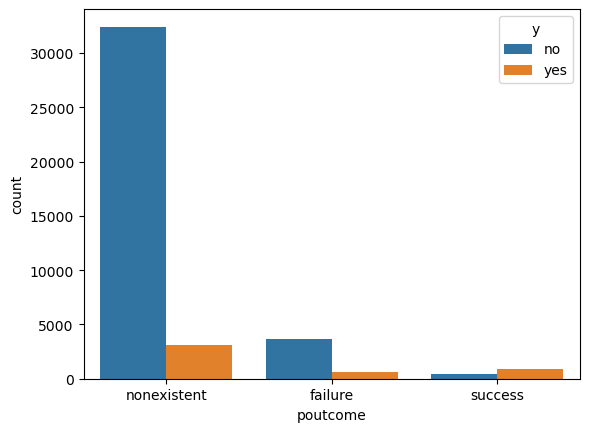

In [69]:
# Create a count plot
sns.countplot(x='poutcome', hue='y', data=df)

# Display the plot
plt.show()

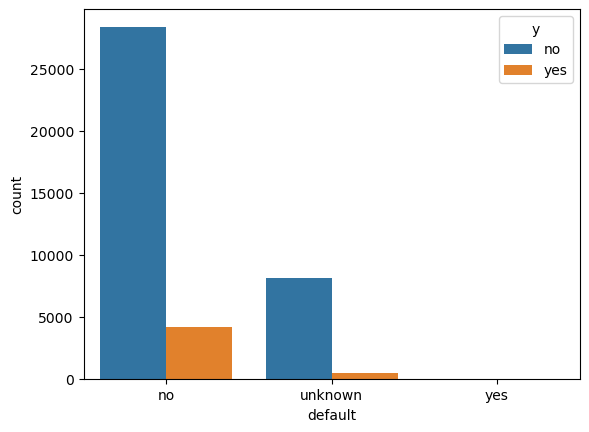

In [70]:
# Create a count plot
sns.countplot(x='default', hue='y', data=df)

# Display the plot
plt.show()

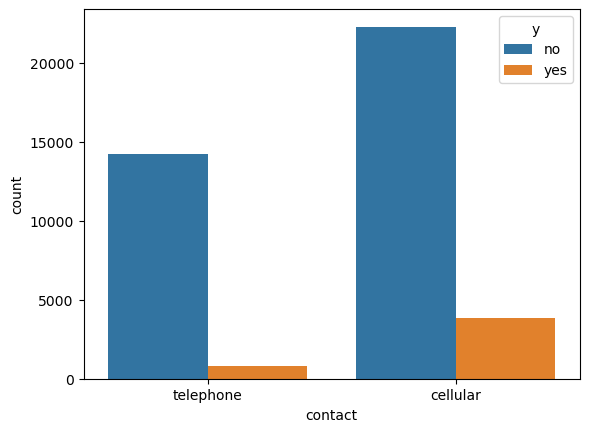

In [71]:
# Create a count plot
sns.countplot(x='contact', hue='y', data=df)

# Display the plot
plt.show()

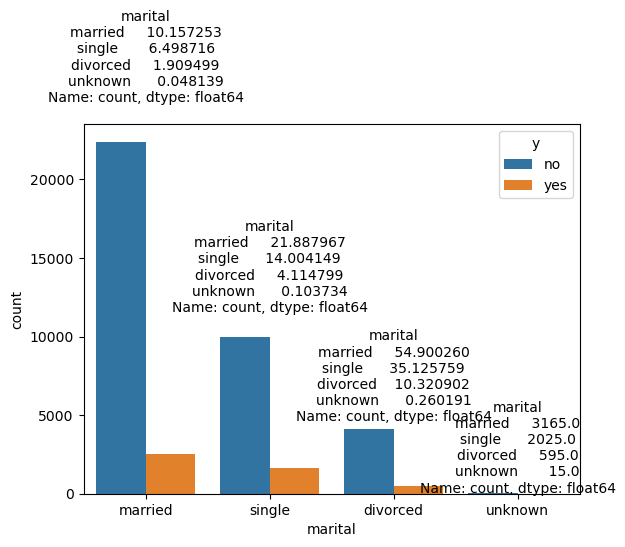

In [72]:
# Create a count plot
sns.countplot(x='marital', hue='y', data=df)

# show percentage of each category and show them in the graph   
# count the number of each category
count = df['marital'].value_counts()
yescnt = df[df['y'] == 'yes']['marital'].value_counts()


#show count in the graph
for i in range(count.shape[0]):
    plt.text(i, count[i], yescnt/count[i]*100, ha = 'center')

        
    

# Display the plot
plt.show()

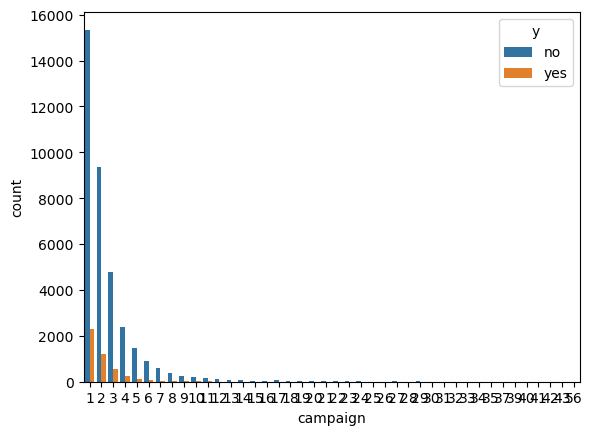

In [73]:
# Create a count plot
sns.countplot(x='campaign', hue='y', data=df)

# Display the plot
plt.show()

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [74]:
# Use make_column_selector to select non-numeric columns
selector = ''

selector = make_column_selector(dtype_include=object)

In [75]:
# Using make_column_transformer to apply OneHotEncoder to non-numeric columns and StandardScaler to numeric columns
transformer = ''

transformer = make_column_transformer((OneHotEncoder(drop = 'first'), selector),
                                     remainder = StandardScaler())

In [76]:
# Feature extraction
extractor = ''

extractor = SelectFromModel(LogisticRegression(penalty='l1', solver = 'liblinear' ,random_state = 42))

In [77]:
# Pipeline
lgr_pipe = ''
lgr_pipe_trainscore = ''
lgr_pipe_testscore = ''

lgr_pipe = Pipeline([('transformer', transformer),
                    ('selector', extractor),
                    ('lgr', LogisticRegression())], verbose=True)

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [78]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['y'], axis = 1), df['y'], random_state = 442,
                                                   stratify = df['y'])

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

Based on the material, the positive response for a mass marketing campaign is less than 1%.

In [79]:
# use DummyClassifier to get the baseline score

dummy_clf = ''
baseline_score = ''

dummy_clf = DummyClassifier().fit(X_train, y_train)
baseline_score = dummy_clf.score(X_test, y_test)

print(baseline_score)


0.8873458288821987


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [80]:
# Using Logistic Regression with default parameters
start_time = time.time()
lgr_pipe.fit(X_train, y_train)
lgr_time = time.time() - start_time

print(lgr_time)


[Pipeline] ....... (step 1 of 3) Processing transformer, total=   0.1s
[Pipeline] .......... (step 2 of 3) Processing selector, total=   1.0s
[Pipeline] ............... (step 3 of 3) Processing lgr, total=   0.1s
1.1607801914215088


### Problem 9: Score the Model

What is the accuracy of your model?

In [81]:
# LGR train score
lgr_pipe_trainscore = lgr_pipe.score(X_train, y_train)

print(lgr_pipe_trainscore)

0.9130491081544787


In [82]:
# LGR test score
lgr_pipe_testscore = lgr_pipe.score(X_test, y_test)

print(lgr_pipe_testscore)

0.9068660774983005


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [83]:
# Using KNN with default parameters
knnpipe = ''
knnpipe_trainscore = ''
knnpipe_testscore = ''

knnpipe = Pipeline([('transform', transformer),
                    ('selector', extractor),
                    ('knn', KNeighborsClassifier())], verbose=True)

start_time = time.time()
knnpipe.fit(X_train, y_train)
knn_time = time.time() - start_time

print(knn_time)

knnpipe_trainscore = knnpipe.score(X_train, y_train)
print(knnpipe_trainscore)

knnpipe_testscore = knnpipe.score(X_test, y_test)
print(knnpipe_testscore)

[Pipeline] ......... (step 1 of 3) Processing transform, total=   0.1s
[Pipeline] .......... (step 2 of 3) Processing selector, total=   0.9s
[Pipeline] ............... (step 3 of 3) Processing knn, total=   0.0s
1.0387957096099854
0.9313392250169953
0.898222783334952


In [84]:
# Using Decision Tree with default parameters
dtreepipe = ''
dtree_trainscore = ''
dtree_testscore = ''

dtreepipe = Pipeline([('transform', transformer),
                    ('selector', extractor),
                    ('dtree', DecisionTreeClassifier())], verbose=True)
start_time = time.time()
dtreepipe.fit(X_train, y_train)
dtree_time = time.time() - start_time

print(dtree_time)

dtree_trainscore = dtreepipe.score(X_train, y_train)
print(dtree_trainscore)

dtree_testscore = dtreepipe.score(X_test, y_test)
print(dtree_testscore)

[Pipeline] ......... (step 1 of 3) Processing transform, total=   0.1s
[Pipeline] .......... (step 2 of 3) Processing selector, total=   1.3s
[Pipeline] ............. (step 3 of 3) Processing dtree, total=   0.2s
1.623878002166748
1.0
0.8867631348936583


In [85]:
# Using SVC with default parameters
svcpipe = ''
svc_trainscore = ''
svc_testscore = ''

svcpipe = Pipeline([('transform', transformer),
                    ('selector', extractor),
                    ('svc', SVC())], verbose=True)
start_time = time.time()
svcpipe.fit(X_train, y_train)
svc_time = time.time() - start_time

print(svc_time)

svc_trainscore = svcpipe.score(X_train, y_train)
print(svc_trainscore)

svc_testscore = svcpipe.score(X_test, y_test)
print(svc_testscore)

[Pipeline] ......... (step 1 of 3) Processing transform, total=   0.1s
[Pipeline] .......... (step 2 of 3) Processing selector, total=   1.2s
[Pipeline] ............... (step 3 of 3) Processing svc, total=   9.3s
10.594715356826782
0.9234728561717005
0.907740118481111


In [86]:
#Create df to compare performance of different models
results_df = ''

res_dict = {'model': ['Logistic Regression', 'KNN', 'Decision Tree', 'SVC'],
           'train score': [lgr_pipe_trainscore, knnpipe_trainscore, dtree_trainscore, svc_trainscore],
           'test score': [lgr_pipe_testscore, knnpipe_testscore, dtree_testscore, svc_testscore],
           'average fit time': [lgr_time, knn_time, dtree_time, svc_time]}
results_df = pd.DataFrame(res_dict).set_index('model')

results_df

,train score,test score,average fit time
model,,,
Logistic Regression,0.913000,0.90100,1.400000
KNN,0.931000,0.89800,1.100000
Decision Tree,1.000000,0.88900,1.400000
SVC,0.923473,0.90774,10.594715


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [87]:
len(X_test)

10297

In [88]:
warnings.filterwarnings('ignore')
knnpipe_grid = ''
knn_grid = ''
best_k = ''
best_acc = ''

### BEGIN SOLUTION
knnpipe_grid = Pipeline([('transform', transformer),
                    ('selector', extractor),
                    ('knn', KNeighborsClassifier())])
params = {'knn__n_neighbors': list(range(1, 50, 2))}
knn_grid = GridSearchCV(knnpipe_grid, param_grid=params)
knn_grid.fit(X_train, y_train)
best_k = list(knn_grid.best_params_.values())[0]
best_acc = knn_grid.score(X_test, y_test)
### END SOLUTION

# Answer check
print('best score -> ' + str(best_acc))
print('best k -> ' + str(best_k))

best score -> 0.8817131203263087
best k -> 1


In [89]:
# tune Logistic Regression
lgrpipe_grid = ''
lgr_grid = ''
best_c = ''
best_acc = ''

### BEGIN SOLUTION
lgrpipe_grid = Pipeline([('transform', transformer),
                    ('selector', extractor),
                    ('lgr', LogisticRegression())])
params = {'lgr__C': [0.01, 0.1, 1, 10, 100]}
lgr_grid = GridSearchCV(lgrpipe_grid, param_grid=params)
lgr_grid.fit(X_train, y_train)
best_c = list(lgr_grid.best_params_.values())[0]
best_acc = lgr_grid.score(X_test, y_test)
### END SOLUTION

# Answer check
print('best score -> ' + str(best_acc))
print('best c -> ' + str(best_c))



best score -> 0.9050208798679227
best c -> 0.01


In [90]:
# tune Decision Tree
dtreepipe_grid = ''
dtree_grid = ''
best_depth = ''
best_acc = ''

### BEGIN SOLUTION
dtreepipe_grid = Pipeline([('transform', transformer),
                    ('selector', extractor),
                    ('dtree', DecisionTreeClassifier())])
params = {'dtree__max_depth': list(range(1, 20))}
dtree_grid = GridSearchCV(dtreepipe_grid, param_grid=params)
dtree_grid.fit(X_train, y_train)
best_depth = list(dtree_grid.best_params_.values())[0]
best_acc = dtree_grid.score(X_test, y_test)
### END SOLUTION

# Answer check
print('best score -> ' + str(best_acc))
print('best depth -> ' + str(best_depth))


best score -> 0.8873458288821987
best depth -> 1


In [91]:
# tune SVC
svcpipe_grid = ''
svc_grid = ''
best_c = ''
best_acc = ''

### BEGIN SOLUTION
svcpipe_grid = Pipeline([('transform', transformer),
                    ('selector', extractor),
                    ('svc', SVC())])
params = {'svc__C': [0.01, 0.1, 1, 10, 100]}
svc_grid = GridSearchCV(svcpipe_grid, param_grid=params)
svc_grid.fit(X_train, y_train)
best_c = list(svc_grid.best_params_.values())[0]
best_acc = svc_grid.score(X_test, y_test)
### END SOLUTION

# Answer check
print('best score -> ' + str(best_acc))
print('best c -> ' + str(best_c))


best score -> 0.8937554627561426
best c -> 0.01


##### Questions